<a href="https://colab.research.google.com/github/ShahViraj11/Plan-Leaf-Disease-Detection/blob/main/tomatodisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade tensorflow keras
import tensorflow as tf
import pandas as pd
from google.colab import auth
import os
import shutil
import random
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [ ]:

auth.authenticate_user()

print('Authenticated')

# Set Google Cloud Project
!gcloud config set project plant-disease-453521

# Install gcsfs to access files
!pip install gcsfs

Authenticated
Updated property [core/project].


In [ ]:
%%capture
!gsutil -m cp -r gs://tomato-cse404/LeavesDataset /content/

In [ ]:
#print folder names within LeavesDataset
!ls /content/LeavesDataset

potato_early_blight  potato_late_blight     Tomato_healthy    Tomato_septoria_leaf_spot
potato_healthy	     Tomato_bacterial_spot  Tomato_leaf_mold


In [ ]:


# Define base dataset directory
base_dir = "/content/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# List of classes within the LeavesDataset
classes = [
    "potato_early_blight", "potato_late_blight", "potato_healthy",
    "Tomato_bacterial_spot", "Tomato_leaf_mold", "Tomato_healthy",
    "Tomato_septoria_leaf_spot"
]

# Create train, val, test directories for each class
for folder in classes:
    os.makedirs(os.path.join(train_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(val_dir, folder), exist_ok=True)
    os.makedirs(os.path.join(test_dir, folder), exist_ok=True)

# Function to split data
def split_data(source, train_dest, val_dest, test_dest, train_size=0.7, val_size=0.15):
    images = os.listdir(source)
    random.shuffle(images)

    train_split = int(len(images) * train_size)
    val_split = int(len(images) * (train_size + val_size))

    train_images = images[:train_split]
    val_images = images[train_split:val_split]
    test_images = images[val_split:]

    for img in train_images:
        shutil.copy(os.path.join(source, img), os.path.join(train_dest, img))
    for img in val_images:
        shutil.copy(os.path.join(source, img), os.path.join(val_dest, img))
    for img in test_images:
        shutil.copy(os.path.join(source, img), os.path.join(test_dest, img))

# Apply the split to all classes
for category in classes:
    source_dir = f"/content/LeavesDataset/{category}"
    split_data(source_dir, f"{train_dir}/{category}", f"{val_dir}/{category}", f"{test_dir}/{category}")



In [ ]:
# Load datasets
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, image_size=(224, 224), batch_size=32, shuffle=True, label_mode="int"
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir, image_size=(224, 224), batch_size=32, shuffle=True, label_mode="int"
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir, image_size=(224, 224), batch_size=32, shuffle=True,  label_mode="int"
)

# Check class names
print(train_ds.class_names)

Found 5942 files belonging to 7 classes.
Found 2350 files belonging to 7 classes.
Found 2324 files belonging to 7 classes.
['Tomato_bacterial_spot', 'Tomato_healthy', 'Tomato_leaf_mold', 'Tomato_septoria_leaf_spot', 'potato_early_blight', 'potato_healthy', 'potato_late_blight']


In [ ]:
#get input shape
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


In [ ]:


# Load MobileNetV2 base
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model.trainable = False  # Freeze layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation="softmax")
])



# Compile model
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Train model
history = model.fit(train_ds, validation_data=val_ds, epochs=10)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 38s 113ms/step - accuracy: 0.5610 - loss: 1.1990 - val_accuracy: 0.8528 - val_loss: 0.4767
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 22s 49ms/step - accuracy: 0.8122 - loss: 0.5360 - val_accuracy: 0.8766 - val_loss: 0.3822
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.8558 - loss: 0.4250 - val_accuracy: 0.8957 - val_loss: 0.3098
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.8689 - loss: 0.3650 - val_accuracy: 0.8979 - val_loss: 0.2880
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - accuracy: 0.8873 - loss: 0.3136 - val_accuracy: 0.9277 - val_loss: 0.2304
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - accuracy: 0.9023 - loss: 0.2811 - val_accuracy: 0.9272 - val_loss: 0.2156
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 11s 58ms/step - accuracy: 0.9105 - loss: 0.2565 - val_accuracy: 0.9455 - val_loss: 0.1692
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 

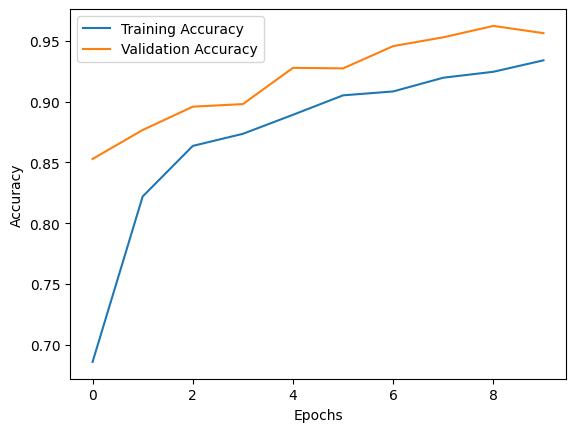

<Figure size 640x480 with 0 Axes>

In [ ]:
#epoch training and validation accuracy graph

history_dict = history.history

plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('accuracy.png')

In [ ]:
#test model on test data
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.9373 - loss: 0.1758
Test accuracy: 0.9397590160369873


In [ ]:
#produce classification report
from sklearn.metrics import classification_report

classes = train_ds.class_names
preds = model.predict(test_ds)
preds = tf.argmax(preds, axis=1)
labels = tf.concat([y for x, y in test_ds], axis=0)

print(classification_report(labels, preds, target_names=classes))

73/73 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step
                           precision    recall  f1-score   support

    Tomato_bacterial_spot       0.17      0.17      0.17       384
           Tomato_healthy       0.15      0.14      0.15       383
         Tomato_leaf_mold       0.14      0.16      0.15       356
Tomato_septoria_leaf_spot       0.14      0.11      0.13       378
      potato_early_blight       0.17      0.17      0.17       379
           potato_healthy       0.00      0.00      0.00        58
       potato_late_blight       0.19      0.20      0.20       386

                 accuracy                           0.16      2324
                macro avg       0.14      0.14      0.14      2324
             weighted avg       0.16      0.16      0.16      2324



73/73 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step


Text(0.5, 1.0, 'Confusion Matrix')

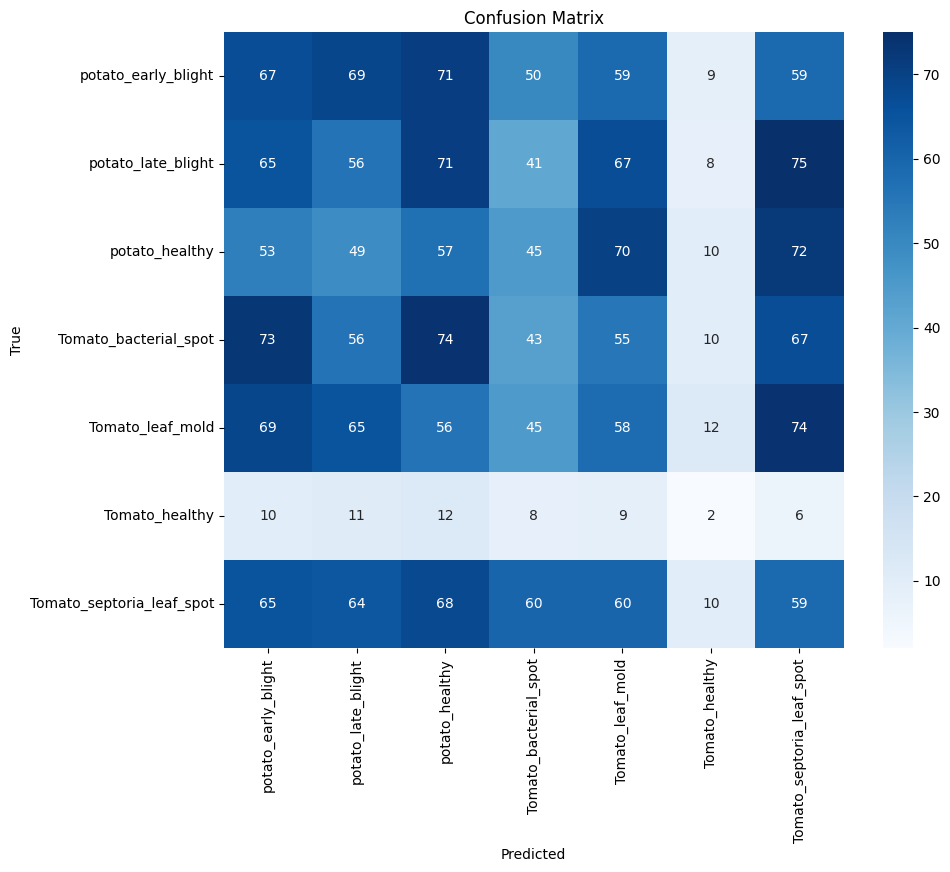

In [ ]:
#bar plot for performance on each class


preds = model.predict(test_ds)
preds = tf.argmax(preds, axis=1)
labels = tf.concat([y for x, y in test_ds], axis=0)

cm = confusion_matrix(labels, preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
